In [2]:
import pandas as pd
import numpy as np

In [3]:
import tensorflow as tf

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.10.0


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.3.1+cpu


## Loading the Data

In [6]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [7]:
#1. tokenization by each word
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [8]:
#2. numeralization
flatten = lambda l: [item for sublist in l for item in sublist] #function to concat lists
vocabs = list(set(flatten(corpus))) #find and store unique words

In [9]:
vocabs

['dog', 'cat', 'fruit', 'apple', 'animal', 'banana']

In [10]:
word2index = {val:index for index, val in enumerate(vocabs)} #create dict with words and their indexes

In [11]:
word2index

{'dog': 0, 'cat': 1, 'fruit': 2, 'apple': 3, 'animal': 4, 'banana': 5}

In [12]:
#The "<UNK>" token stands for "unknown" and is used to handle words that are not in our vocabulary
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [13]:
#creating reverse dictionary to map indices back to words
index2word = {word:index for index, word in word2index.items()}
index2word[5]

'banana'

## Preparing data for training

In [14]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

   
    for doc in corpus:
        
        for i in range(1, len(doc)-1):
            
            center = word2index[doc[i]]
            
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
           
            for each_out in outside:
                skipgrams.append([center, each_out])
                
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)

In [15]:
x, y = random_batch(2, corpus)

In [16]:
x

array([[0],
       [0]])

In [17]:
y

array([[1],
       [4]])

## Model

In [18]:
len(vocabs)

7

In [19]:
embedding = nn.Embedding(7, 2)

In [20]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape

torch.Size([2, 1, 2])

In [21]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss

In [22]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [23]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [24]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [25]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [26]:
loss

tensor(2.4461, grad_fn=<NegBackward0>)

## Model Training

In [29]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [30]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.5f}")

Epoch   1000 | Loss: 2.86781
Epoch   2000 | Loss: 1.43049
Epoch   3000 | Loss: 1.47474
Epoch   4000 | Loss: 1.30535
Epoch   5000 | Loss: 1.15549
Epoch   6000 | Loss: 1.09317
Epoch   7000 | Loss: 1.15019
Epoch   8000 | Loss: 1.11086
Epoch   9000 | Loss: 1.07623
Epoch  10000 | Loss: 1.12664


## Plotting the Embeddings

In [31]:
vocabs


['dog', 'cat', 'fruit', 'apple', 'animal', 'banana', '<UNK>']

In [32]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([5])

In [33]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[0.2419, 0.5242]], grad_fn=<DivBackward0>)

In [34]:
banana_embed_o

tensor([[ 0.8777, -0.4497]], grad_fn=<EmbeddingBackward0>)

In [35]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

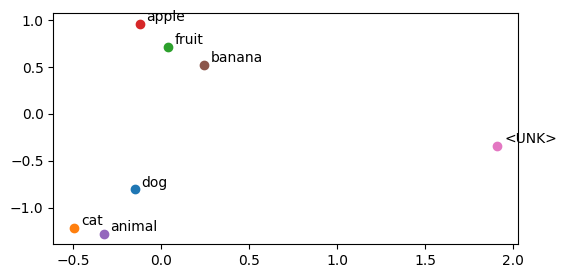

In [36]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()